<a href="https://colab.research.google.com/github/KhafillahAkbar/MachLearn_Ganjil_2023/blob/main/Quiz2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import imutils
import cv2
from tensorflow.keras.models import load_model
from imutils.contours import sort_contours
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt

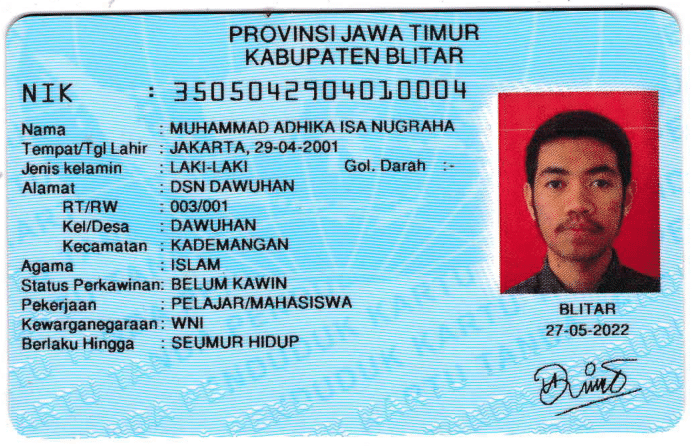

In [3]:
img = cv2.imread("12_Muhammad Adhika Isa Nugraha.png")
cv2_imshow(img)

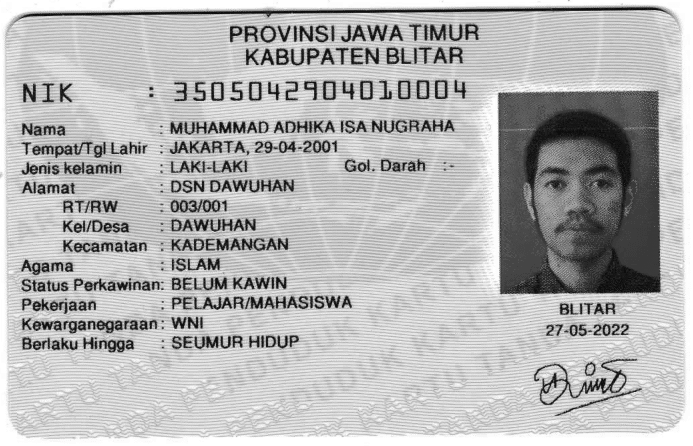

In [5]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# show
cv2_imshow(gray)

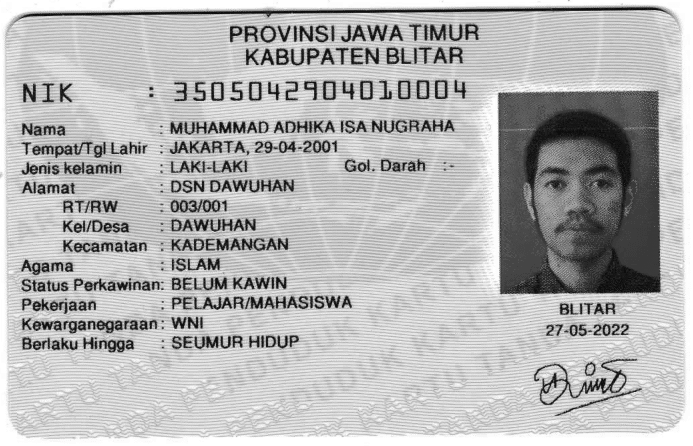

In [13]:
blurred = cv2.GaussianBlur(gray, (1, 1), 0.5)
cv2_imshow(blurred)

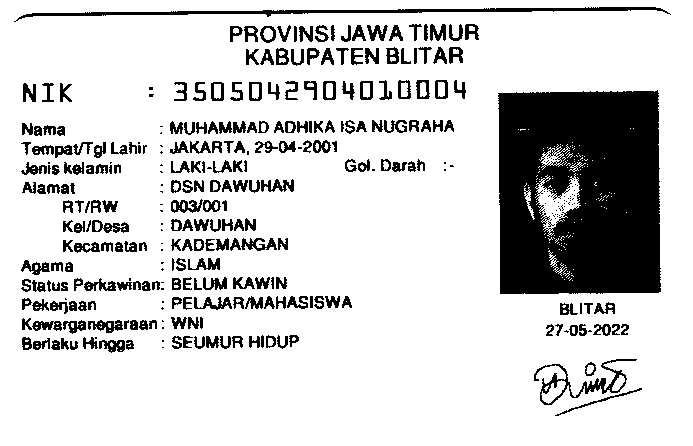

In [17]:
ret, bw = cv2.threshold(blurred.copy(), 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

erode = cv2.erode(bw.copy(),cv2.getStructuringElement(cv2.MORPH_OPEN,(1,1)),)

cv2_imshow(erode)


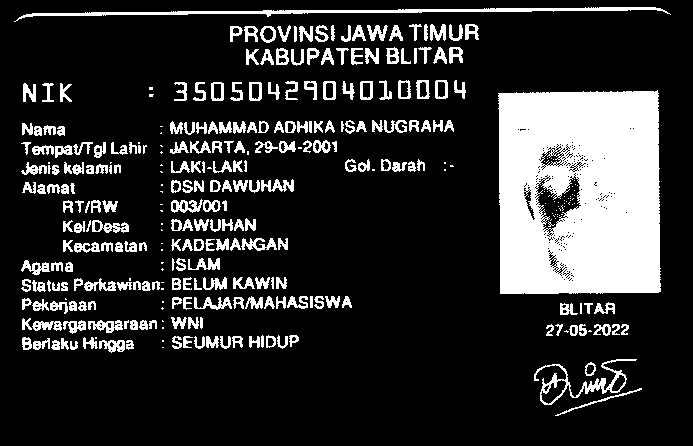

In [18]:
# inverse image since we trained out model
# with black background
invertion = 255 - erode
# check
cv2_imshow(invertion)

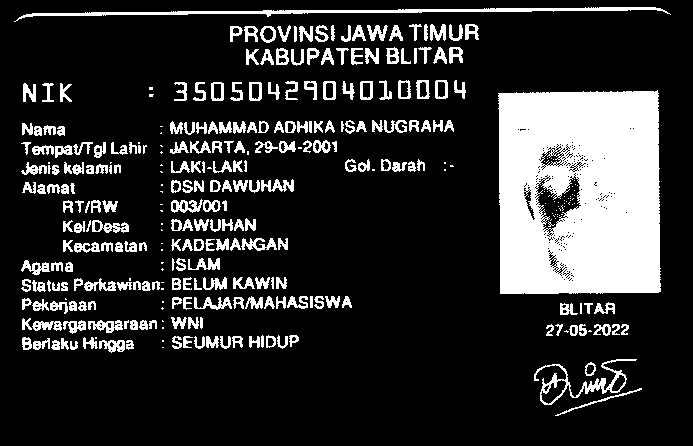

In [52]:
# Test erode
num_iterations = 10

# Apply erosion iteratively
for i in range(num_iterations):
    invertion = cv2.erode(invertion, np.ones((1, 1)))

cv2_imshow(invertion)

In [22]:
# Define function for contour detection
def find_contours(img):
  conts = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  conts = imutils.grab_contours(conts)
  conts = sort_contours(conts, method='left-to-right')[0]

  return conts


In [23]:
conts = find_contours(invertion.copy())

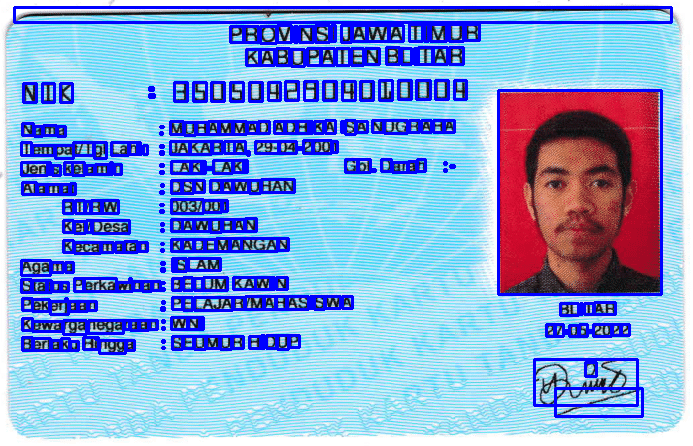

In [24]:
# Get the char based on contour

# Setup min/max width/hight for char
# min_w, max_w = 10, 160
# min_h, max_h = 14, 140
img_copy = img.copy()

for c in conts:
  (x, y, w, h) = cv2.boundingRect(c) # find bounding box based on contour
  # if(w >= min_w and w <= max_w) and (h >= min_h and h <= max_h): # if pixel follow this rule, it consider as char
  roi = gray[y:y+h, x:x+w] # get region of interest for char
  thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
  # cv2_imshow(thresh) # check

  # Build bounding box on original image
  cv2.rectangle(img_copy, (x,y), (x+w, y+h), (255,0,0), 2)

# Show bounding box on original image
cv2_imshow(img_copy)

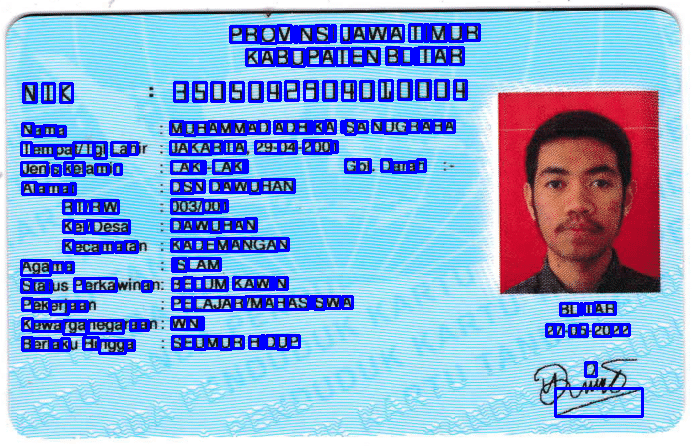

In [25]:
# Get the char based on contour

# Setup min/max width/hight for char
min_w, max_w = 2, 100
min_h, max_h = 10, 100
img_copy = img.copy()

for c in conts:
  (x, y, w, h) = cv2.boundingRect(c) # find bounding box based on contour
  if(w >= min_w and w <= max_w) and (h >= min_h and h <= max_h): # if pixel follow this rule, it consider as char
    roi = gray[y:y+h, x:x+w] # get region of interest for char
    thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    cv2_imshow(thresh) # check

    # Build bounding box on original image
    cv2.rectangle(img_copy, (x,y), (x+w, y+h), (255,0,0), 2)

# Show bounding box on original image
cv2_imshow(img_copy)

In [26]:
def extract_roi(img):
  roi = img[y:y+h, x:x+w]

  return roi

In [27]:
def thresholding(img):
  thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
  return thresh

In [28]:
def resize_img(img, w, h):
  if w > h:
    resized = imutils.resize(img, width=28)
  else:
    resized = imutils.resize(img, height=28)

  # (w, h) = resized.shape
  (h, w) = resized.shape

  # Calculate how many pixels need to fill char image
  dX = int(max(0, 28 - w) / 2.0)
  dY = int(max(0, 28 - h) / 2.0)

  filled = cv2.copyMakeBorder(resized, top=dY, bottom=dY, right=dX, left=dX, borderType=cv2.BORDER_CONSTANT, value=(0,0,0))
  filled = cv2.resize(filled, (28,28))

  return filled

In [30]:

# Demo for enlarge
(x, y, w, h) = cv2.boundingRect(conts[1])
test_image = thresholding(gray[y:y+h, x:x+w])

# show original test image
cv2_imshow(test_image)

# Show enlarge test image
cv2_imshow(cv2.resize(test_image, (28,28)))


In [31]:
# Demo by filled strategy
# (w, h) = test_image.shape
(h, w) = test_image.shape

test_image2 = resize_img(test_image, w, h)

cv2_imshow(test_image)
cv2_imshow(test_image2)

In [32]:
def normalization(img):
  img = img.astype('float32') / 255.0 # convert to floating point
  img = np.expand_dims(img, axis=-1) # add depth
  return img

In [33]:
# Check
test_image2.shape, normalization(test_image2).shape


((28, 28), (28, 28, 1))

In [34]:
def process_box(gray, x, y, w, h):

  roi = extract_roi(gray)
  thresh = thresholding(roi)
  (h, w) = thresh.shape
  resized = resize_img(thresh, w, h)

  # show result
  cv2_imshow(resized)

  normalized = normalization(resized)

  return (normalized, (x, y, w, h))

In [35]:
# Detect every single char from contour
detected_char = []

for c in conts:
  (x, y, w, h ) = cv2.boundingRect(c)

  min_w, max_w = 2, 100
  min_h, max_h = 10, 100

  if(w >= min_w and w <= max_w) and (h >= min_h and h <= max_h):
    detected_char.append(process_box(gray, x, y, w, h))

In [36]:
digits = '0123456789'
letters = 'ABCDEFGHIJKLMNOPQRSTUVWZYZ'
char_list = digits + letters
char_list = [ch for ch in char_list]

print(char_list)


['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Z', 'Y', 'Z']


In [38]:
network = load_model('network')
# check summary
network.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 2, 2, 128)         0

In [39]:

# Get all char pixel
pixels = np.array([px[0] for px in detected_char], dtype='float32')

# Get all box for detected char
boxes = [box[1] for box in detected_char]

In [40]:

# Predict
preds = network.predict(pixels)

# check shape -> JTI POLINEMA --> shoud be 11 (from 0 to 10)
preds.shape

8/8 [==============================] - 0s 11ms/step


(235, 36)

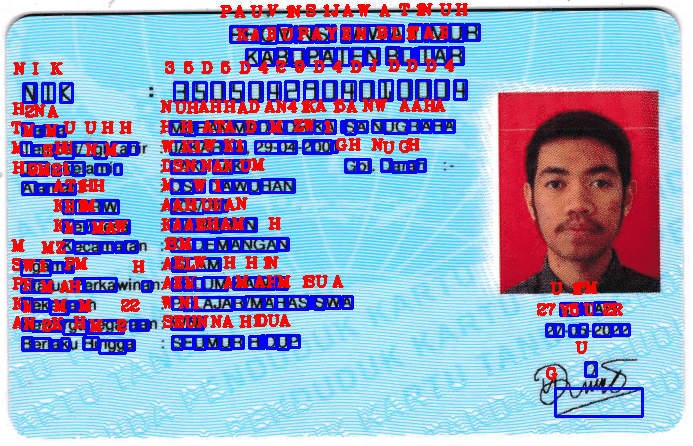

In [42]:
# Show char with actual image
img_copy3 = img.copy()

for(pred, (x, y, w, h)) in zip(preds, boxes):
  i = np.argmax(pred)
  char_detected = char_list[i]

  cv2.rectangle(img_copy3, (x, y), (x+w, y+h), (255,0,0), 2)
  cv2.putText(img_copy3, char_detected, (x - 10, y - 10), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0,0,255), 2)

cv2_imshow(img_copy3)

In [43]:
# Redefine roi --> include margin
def extract_roi(img, margin=2):
  roi = img[y - margin:y+h, x - margin:x + w + margin]
  return roi

In [45]:

# Perform detection agian
conts2 = find_contours(invertion.copy())

# Detect every single char from contour
detected_char = []

for c in conts2:
  (x, y, w, h ) = cv2.boundingRect(c)

  min_w, max_w = 2, 100
  min_h, max_h = 10, 100

  if(w >= min_w and w <= max_w) and (h >= min_h and h <= max_h):
    detected_char.append(process_box(gray, x, y, w, h))


In [46]:
# Get all char pixel
pixels = np.array([px[0] for px in detected_char], dtype='float32')

# Get all box for detected char
boxes = [box[1] for box in detected_char]

In [47]:
# Predict
preds = network.predict(pixels)

# check shape -> JTI POLINEMA --> shoud be 11 (from 0 to 10)
preds.shape


8/8 [==============================] - 0s 13ms/step


(235, 36)

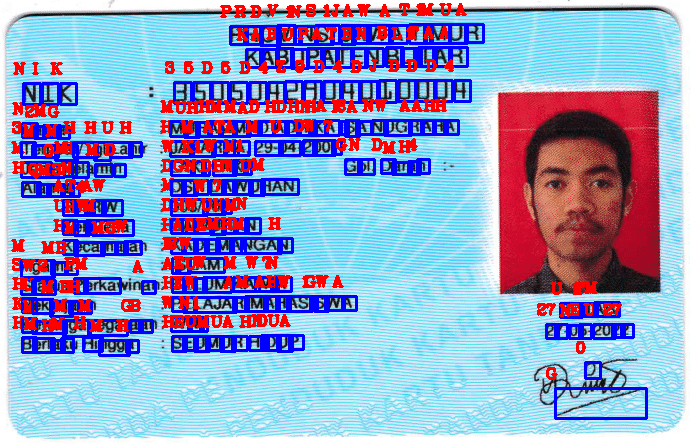

In [48]:
# Show char with actual image
img_copy3 = img.copy()

for(pred, (x, y, w, h)) in zip(preds, boxes):
  i = np.argmax(pred)
  char_detected = char_list[i]

  cv2.rectangle(img_copy3, (x, y), (x+w, y+h), (255,0,0), 2)
  cv2.putText(img_copy3, char_detected, (x - 10, y - 10), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0,0,255), 2)

cv2_imshow(img_copy3)